In [1]:
import pytz
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Headers for requests
headers = {
    'accept': 'application/json, text/plain, */*',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36',
}

# Set timezone to UTC and then convert to America/Los_Angeles
utc_now = datetime.utcnow().replace(tzinfo=pytz.utc)
la_now = utc_now.astimezone(pytz.timezone('America/Los_Angeles'))

# Get current week number and date in Los Angeles time
week_number = la_now.isocalendar().week
today_la = la_now.strftime('%Y-%m-%d')

# Use timestamp for cacheBust
cache_bust = int(la_now.timestamp())

# Format the URL dynamically
url = f'https://data.lacity.org/api/views/s49e-q6j2/rows.csv?fourfour=s49e-q6j2&cacheBust={cache_bust}&date={today_la}&accessType=DOWNLOAD'

# Fetch the data
try:
    inventory = pd.read_csv(url, storage_options=headers)  # Ensure headers are being used if required
    inventory.columns = inventory.columns.str.lower()

    # Splitting the LatLng into separate columns for latitude and longitude
    inventory[['latitude', 'longitude']] = inventory['latlng'].str.extract(r'\((.*), (.*)\)')

    # Convert the Latitude and Longitude from string to float
    inventory['latitude'] = inventory['latitude'].astype(float)
    inventory['longitude'] = inventory['longitude'].astype(float)

    # Create Point geometries
    inventory['geometry'] = inventory.apply(lambda row: Point((row['longitude'], row['latitude'])), axis=1)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(inventory, geometry='geometry')

    # Set the coordinate reference system (CRS) to WGS 84 (EPSG:4326)
    gdf.set_crs(epsg=4326, inplace=True)

    # Drop the original LatLng column
    gdf.drop('latlng', axis=1, inplace=True)

    def update_locations(gdf):
        # Define the corrections in a dictionary
        corrections = {
            '671 S Serrano Ave': {'latitude': 34.0608642, 'longitude': -118.3066224},
            '689 S Serrano Ave': {'latitude': 34.0603878, 'longitude': -118.3093599}
        }

        # Loop over the corrections and apply them
        for address, coords in corrections.items():
            gdf.loc[gdf['blockface'] == address, ['latitude', 'longitude']] = coords['latitude'], coords['longitude']
            # Update the geometry column based on the new coordinates
            gdf['geometry'] = gdf.apply(lambda row: Point((row['longitude'], row['latitude'])), axis=1)

        return gdf

    # Call the function to update locations
    gdf = update_locations(gdf)
except Exception as e:
    print(f"Failed to retrieve or process data: {e}")

# Identify entries with negative latitudes
negative_lat = gdf[gdf['latitude'] < 0]
print("Entries with negative latitudes:")
print(negative_lat[['blockface', 'latitude', 'longitude']])

# If the negative value is simply a sign error, correct it:
if len(negative_lat) == 1 and negative_lat['latitude'].iloc[0] == -34.197632:
    # Correcting by changing the sign
    gdf.loc[gdf['latitude'] < 0, 'latitude'] = gdf['latitude'].abs()

    # Update the geometry column to reflect the corrected latitude
    gdf['geometry'] = gdf.apply(lambda row: Point((row['longitude'], row['latitude'])), axis=1)
    print("Latitude corrected for entries with incorrect negative values.")
else:
    print("Manual review required for negative latitude entries.")

Entries with negative latitudes:
           blockface   latitude   longitude
32595  18500 HART ST -34.197632 -118.536355
Latitude corrected for entries with incorrect negative values.


In [2]:
len(gdf)

35318

In [3]:
lahoods = gpd.read_file('https://s3.us-west-1.amazonaws.com/stilesdata.com/la/la_city_hoods_county_munis.geojson')

In [4]:
keep = ['spaceid', 'blockface', 'metertype', 'ratetype', 'raterange', 'meteredtimelimit', 'name', 'city', 'region', 'latitude', 'longitude', 'geometry']
gdf_merged = gpd.sjoin(gdf, lahoods[['name', 'city', 'region', 'geometry']], predicate='intersects').drop(['index_right', ], axis=1)[keep]

In [5]:
gdf_merged.head()

,spaceid,blockface,metertype,ratetype,raterange,meteredtimelimit,name,city,region,latitude,longitude,geometry
0,WW1218,4200 3RD ST,Single-Space,FLAT,$1.00,1HR,Koreatown,los-angeles,central-la,34.068886,-118.306322,POINT (-118.30632 34.06889)
1,VW1958,1701 HOOVER ST,Single-Space,FLAT,$1.00,1HR,Pico-Union,los-angeles,central-la,34.042304,-118.284271,POINT (-118.28427 34.04230)
2,CB2210,801 S SAN JULIAN ST,Single-Space,TOD,$0.50 - $6.00,2HR,Downtown,los-angeles,central-la,34.038399,-118.250914,POINT (-118.25091 34.03840)
3,AE412,500 VIGNES ST,Single-Space,JUMP,$1.00/H - $4.00/10H,10HR,Downtown,los-angeles,central-la,34.052172,-118.233119,POINT (-118.23312 34.05217)
4,W190,5300 W CENTURY BLVD,Single-Space,FLAT,$1.00,2HR,Westchester,los-angeles,south-bay,33.945157,-118.371691,POINT (-118.37169 33.94516)


In [6]:
gdf_merged.to_file('data/parking_meters_inventory_latest.geojson', driver='GeoJSON')

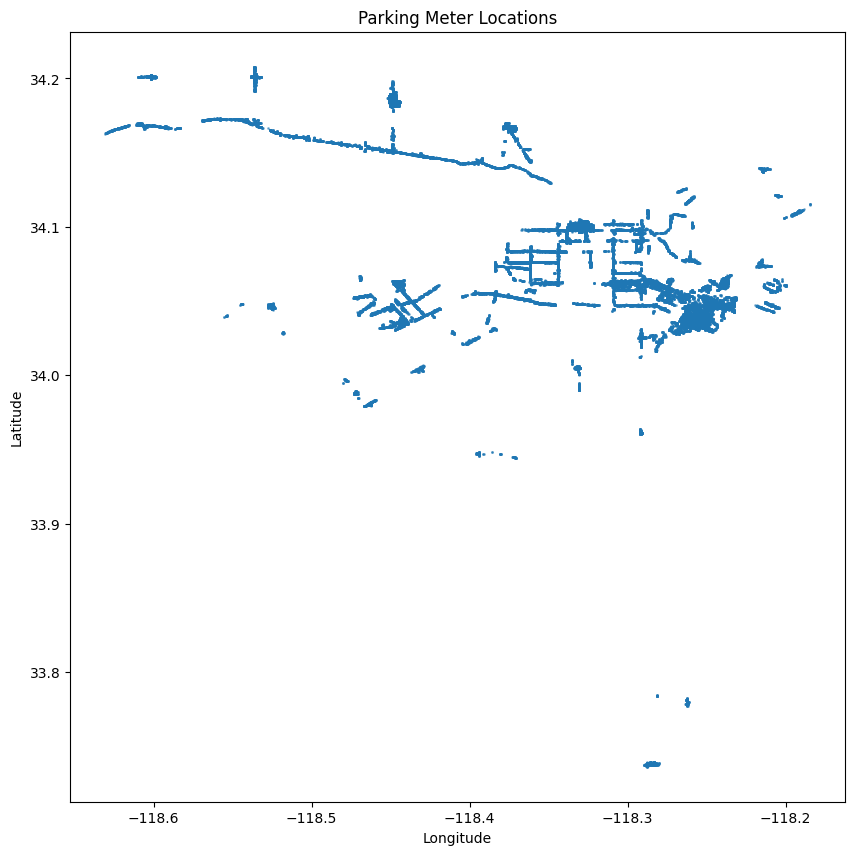

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Adjust circle sizes using the 's' parameter (e.g., 10 for smaller circles, 100 for larger)
gdf.plot(ax=ax, kind='scatter', x='longitude', y='latitude', alpha=0.5, s=1)  # 's=50' makes the markers moderately sized
ax.set_title('Parking Meter Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()